In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case9'
model_name = 'case9_modflow'
model_ws = './models_folder/' + data_folder

Lx = 510.0
Ly = 310.0

nrow = 31
ncol = 51
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

top = 10.0
botm = 0.0

laytyp = 1

hk = 50.0

nper = 1
perlen = [500,]
nstp = [50,]
steady = [True,]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc, top=top, botm=botm,
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, :, 0] = -1
ibound[0, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32) * 99.0
strt[0, :, 0] = 100.0
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=laytyp, ipakcb=53, ss=1)

chd_spd = []
for i in range(nrow):
    chd_spd.append([0, i, 0, 100.0, 100.0])
    chd_spd.append([0, i, ncol-1, 99.0, 99.0])

chd_spd = {0: chd_spd}
chd = flopy.modflow.ModflowChd(model, stress_period_data=chd_spd)

wel_spd = {0: [[0, 15, 15, 2.0],],}
wel = flopy.modflow.ModflowWel(model, ipakcb=66, stress_period_data=wel_spd, unitnumber=78)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data)#, compact=True)

pcg = flopy.modflow.ModflowPcg(model=model, hclose=0.001, rclose=0.001, relax=1.0, nbpol=1.0, iprpcg=1.0, mutpcg=0)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  1.0


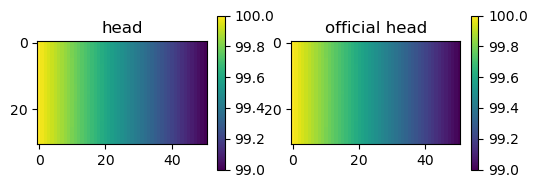

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex09_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.imshow(head[-1, 0])
plt.title("head")
plt.colorbar()
plt.subplot(122)
plt.imshow(head_official[-1, 0])
plt.title("official head")
plt.colorbar()

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./",
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=0,
    ph_ph=0,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/case9\\pht3d_ph.dat'

In [5]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

## Initiate RCH data...
# rch_spec={}
# for key in spec.keys():
#    rch_spec[key]={}

for i in range(1):
    # rch and wel
    for key in spec.keys():
        # rch_spec[key][i]=spec[key][0,:,:]
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['ph'] = 7
    wel_spec['pe'] = 4

    wel_spec['o0'] = 0.0
    wel_spec['n5'] = 0.0
    wel_spec['fe2'] = 0.0
    wel_spec['s6'] = 0.0
    wel_spec['meth'] = 0.0
    wel_spec['cl'] = 0.002
    wel_spec['na'] = 0.002
    wel_spec['hycarb'] = 0.0108696

    ssm_per=[0,15,15,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0,
  15,
  15,
  0.0,
  2,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.002,
  0.002,
  0.0108696,
  7,
  4]}

In [6]:
model_name = "case9_mt3dms"
icbund = np.abs(ibound)
icbund[0, :, 0] = -1

## Initiate model object
mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 0.3
save_times = np.arange(0, 520, 20)

exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp, dz=10, \
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=1, mxstrn=50000, tsmult=1, timprs=save_times, \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75, mxpart=5000, nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=10, trpt=0.3, trpv=0.1, multiDiff=True, dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=2, cclose=1.e-12)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

DSP: setting dmcoef for component 2 to zero, kwarg name dmcoef2
DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4
DSP: setting dmcoef for component 5 to zero, kwarg name dmcoef5
DSP: setting dmcoef for component 6 to zero, kwarg name dmcoef6
DSP: setting dmcoef for component 7 to zero, kwarg name dmcoef7
DSP: setting dmcoef for component 8 to zero, kwarg name dmcoef8


In [7]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [8]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    10.000    

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:   10.00     Total Elapsed Time:   10.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2504      [K,I,J]    1    1   51
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4805E-02  [K,I,J]    1   31   50
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9312E-04  [K,I,J]    1   31   49
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1689E-05  [K,I,J]    1   29   48
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3403E-07  [K,I,J]    1   31   48
 Outer Iter.  1  Inner Iter.  6:  Max

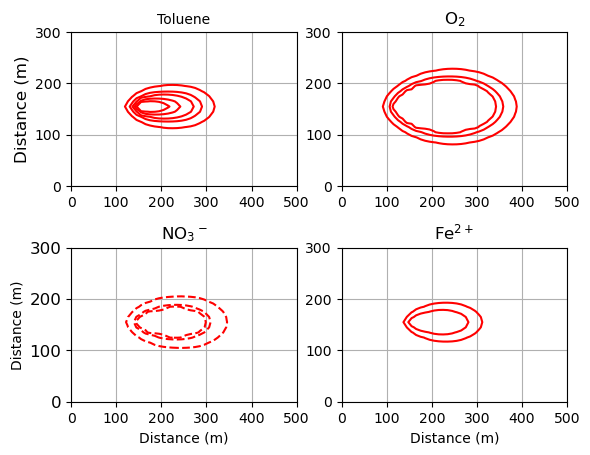

In [9]:
O_0  = np.loadtxt(model_ws+'/PHT3D001.ACN') * 1000 * 15.999
N_5  = np.loadtxt(model_ws+'/PHT3D002.ACN') * 1000 * 62.005
Fe_2 = np.loadtxt(model_ws+'/PHT3D003.ACN') * 1000 * 55.845
Tol  = np.loadtxt(model_ws+'/PHT3D008.ACN') * 1000 * 92.14

ncol = 51
nrow = 31
nlay = 1
ncells = ncol * nrow

dt = 20
nt = len(O_0) // ncells
times = np.arange(0, nt * dt, dt)

int_Tol  = np.array([1, 5, 10, 20, 30])
int_O_0  = np.array([0.5, 2.0, 3.5])
int_N_5  = np.array([1, 4, 16])
int_Fe_2 = np.array([2, 8, 32])

x = np.arange(5, 510, 10)
y = np.arange(5, 310, 10)
X, Y = np.meshgrid(x, y)

plt.close()

n = 0
for t in times:
    if t == 360:
        plt.clf()

        plt.subplot(2, 2, 1)
        plot_Tol = np.reshape(Tol[n * ncells : (n + 1) * ncells], (nrow, ncol))
        plt.contour(X, Y, plot_Tol, int_Tol, colors='r')
        plt.axis([0, 500, 0, 300])
        plt.grid(True)
        plt.title('Toluene', fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.ylabel('Distance (m)', fontsize=12)

        plt.subplot(2, 2, 2)
        plot_O_0 = np.reshape(O_0[n * ncells : (n + 1) * ncells], (nrow, ncol))
        plt.contour(X, Y, plot_O_0, int_O_0, colors='r')
        plt.axis([0, 500, 0, 300])
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True)
        plt.title(r'O$_2$', fontsize=12)

        plt.subplot(2, 2, 3)
        plot_N_5 = np.reshape(N_5[n * ncells : (n + 1) * ncells], (nrow, ncol))
        plt.contour(X, Y, plot_N_5, int_N_5, colors='r', linestyles='--')
        plt.axis([0, 500, 0, 300])
        plt.xlabel('Distance (m)', fontsize=10)
        plt.xticks(fontsize=10)
        plt.ylabel('Distance (m)', fontsize=10)
        plt.yticks(fontsize=12)
        plt.grid(True)
        plt.title(r'NO$_{3}$$^-$', fontsize=12)

        plt.subplot(2, 2, 4)
        plot_Fe_2 = np.reshape(Fe_2[n * ncells : (n + 1) * ncells], (nrow, ncol))
        plt.contour(X, Y, plot_Fe_2, int_Fe_2, colors='r')
        plt.axis([0, 500, 0, 300])
        plt.xlabel('Distance (m)', fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(True)
        plt.title(r'Fe$^{2+}$', fontsize=12)

        plt.draw()

    n += 1

plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.4, wspace=None)